# BPによる可視化

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.autograd import Variable
SYNSET_FILE='synset_words.txt'  # ImageNet1000 種類のカテゴリ名が書かれたファイル．
synset=open(SYNSET_FILE).read().split('\n')

In [31]:
img = Image.open('bird.jpg')

In [32]:
vgg16 = models.vgg16(pretrained=True,progress=True)
softmax=nn.Softmax(dim=1)

In [34]:
vgg16.eval() 
image_size = (224, 224) 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image_transform = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor(),normalize])
img = Image.open('bird.jpg')
img = image_transform(img)
img = img.unsqueeze(0)
with torch.no_grad():
    out=softmax(vgg16(img)).numpy()[0]
img = Variable(img, requires_grad=True)
dzdy =torch.zeros([1,1000])
dzdy[0][np.argmax(out)]=1
vgg16(img)[0].backward(dzdy)
print(img.grad.numpy()[0].shape)

(3, 224, 224)


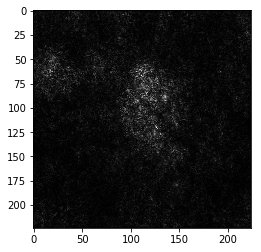

In [35]:
out = np.abs(img.grad.numpy()[0])
out = out.max(axis = 0)
maxv = out.max()
out1 = out/maxv
plt.imshow(out1,'gray')

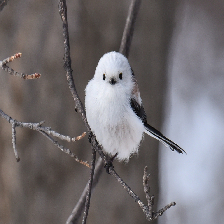

In [36]:
img = Image.open('bird.jpg')
img = img.resize((224,224))
img

# SmoothGradによる可視化

In [37]:
import chainer
import chainer.functions as F
from chainer.variable import Variable
from chainer.links import VGG16Layers
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
chainer.config.train=False
chainer.config.enable_backprop=True

In [38]:
model = VGG16Layers()

In [39]:
image = Image.open("bird.jpg")
image = image.resize((224,224))
sampleSize = 100
noiseLevel = 0.2 # 20%
sigma = noiseLevel*255.0
gradList = []
for _ in range(sampleSize):
    x = np.asarray(image, dtype=np.float32)
    # RGB to BGR
    x = x[:,:,::-1]
    # 平均を引く
    x -= np.array([103.939, 116.779, 123.68], dtype=np.float32)
    x = x.transpose((2, 0, 1))
    x = x[np.newaxis]
    # ノイズを追加
    x += sigma*np.random.randn(x.shape[0],x.shape[1],x.shape[2],x.shape[3])    
    x = Variable(np.asarray(x))
    # FPして最終層を取り出す
    y = model(x, layers=['prob'])['prob']
    # 予測が最大のラベルでBP
    t = np.zeros((x.data.shape[0]),dtype=np.int32)
    t[:] = np.argmax(y.data)
    t = Variable(np.asarray(t))
    loss = F.softmax_cross_entropy(y,t)
    loss.backward()
    # 勾配をリストに追加
    grad = np.copy(x.grad)
    gradList.append(grad)
    # 勾配をクリア
    model.cleargrads()

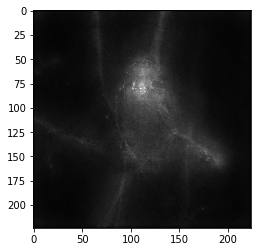

In [40]:
G = np.array(gradList)
M = np.mean(np.max(np.abs(G),axis=2),axis=0)
M = np.squeeze(M)
plt.imshow(M,"gray")
plt.show()

# Guided BPによる可視化

In [41]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K

import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np
import matplotlib.pyplot as plt


def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x


def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)


def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # 活性化関数があるレイヤーの保存
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # reluを置き換える
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model


def guided_backpropagation(img_tensor, model, activation_layer):
    model_input = model.input
    layer_output = model.get_layer(activation_layer).output

    max_output = K.max(layer_output, axis=3)

    get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
    saliency = get_output([img_tensor])

    return saliency[0]



img_width = 224
img_height = 224

model = VGG16(weights='imagenet')


img_path = 'bird.jpg'
img = load_image(path=img_path, target_size=(img_width, img_height))
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
gradient = guided_backpropagation(img, guided_model, "block5_conv3")

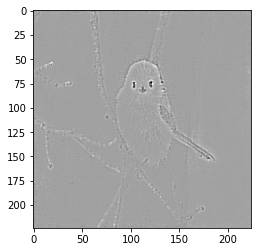

In [42]:
out = np.transpose(gradient[0], (2,0,1))
out = out.max(axis = 0)
maxv = out.max()
out = out/maxv

plt.imshow(out,'gray')


# 考察
 3種類の物体位置推定を行った。1つ目のBPを用いた推定ではノイズが多かったものの鳥がいる位置周辺の勾配が大きなことが分かった。2つ目のSmoothGradを用いたものでは入力画像にノイズを与え複数の画像の勾配の平均を求めているために鳥と枝がはっきりわかるような画像が抽出された。Guided BPを用いた手法では、relu関数で活性化された場所のみを逆伝播させているために、1つ目と比べてノイズが少なくなっていることが分かる。